<a href="https://colab.research.google.com/github/frederik-kilpinen/ASDS2/blob/main/Notebooks/topic_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
pip install nltk==3.4

In [8]:
#Importing erlevant packages 
import numpy as np
import pandas as pd
from datetime import datetime 
from tqdm import tqdm 
import logging 
import sys 
import pickle 
import requests
import io

#Importing NLTK and NLP packages
import nltk
from nltk.tokenize import TweetTokenizer
import string
import re
from collections import defaultdict

nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

#Importing packages for data visualization 
import matplotlib.pyplot as plt
import seaborn as sns

#Importing packages for LDA
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamulticore import LdaMulticore

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
#Importing and viewing data
tweets = pd.read_csv("/content/drive/MyDrive/Digital methods/final_tweet_df")

In [10]:
# Subsetting data (should be removed with new dataset)
tweets.loc[(tweets["created_at"] >= "2018-06-01") & (tweets["created_at"] <= "2021-05-01")]

Unnamed: 0  ... lp.official_legislative_period
16              16  ...                             46
17              17  ...                             46
18              18  ...                             46
19              19  ...                             46
20              20  ...                             46
...            ...  ...                            ...
299035      299035  ...                             46
299036      299036  ...                             46
299037      299037  ...                             46
299038      299038  ...                             46
299039      299039  ...                             46

[170514 rows x 17 columns]

In [11]:
#Reusing and tweaking the function for preprocessing from last week to fit specifics of this dataset.
def preprocess(text):
    
    #Lowercasing words
    text = str(text)
    text = text.lower()
    
    #Removing '&amp' which was found to be common
    text = re.sub(r'&amp','', text)
    
    #Replace other instances of "&" with "and"
    text = re.sub(r'&','and', text)
    
    #Removing mentions 
    text = re.sub(r'@\w+ ', '', text)
    
    #Removing 'RT' and 'via'
    text = re.sub(r'(^rt|^via)((?:\b\W*@\w+)+): ', '', text)
    
    #Removing punctuation
    my_punctuation = string.punctuation.replace('#','')
    my_punctuation = my_punctuation.replace('-','')
    
    text = text.translate(str.maketrans('', '', my_punctuation))
    text = re.sub(r' - ','', text) #removing dash lines bounded by whitespace (and therefore not part of a word)
    text = re.sub(r'[’“”—,!]','',text) #removing punctuation that is not captured by string.punctuation
    
    #Removing odd special characters
    text = re.sub(r"[┻┃━┳┓┏┛┗]","", text)
    text = re.sub(r"\u202F|\u2069|\u200d|\u2066","", text)
    
    #Removing URLs
    text = re.sub(r'http\S+', '', text)
    
    #Removing numbers
    text = re.sub(r'[0-9]','', text)
    
    #Removing separators and superfluous whitespace
    text = text.strip()
    text = re.sub(r' +',' ',text)
    
    #Tokenizing
    tokenizer = TweetTokenizer()
    tokens = tokenizer.tokenize(text)
    
    return tokens
    

def preprocess_lemma(tokens):
    
    #Running the preprocess function
    tokens = preprocess(tokens)
    
    #Lemmatizing
    tag_map = defaultdict(lambda : nltk.corpus.wordnet.NOUN)      #POS map
    tag_map['J'] = nltk.corpus.wordnet.ADJ
    tag_map['V'] = nltk.corpus.wordnet.VERB
    tag_map['R'] = nltk.corpus.wordnet.ADV    
    
    lemmatizer = nltk.WordNetLemmatizer()             #Creating lemmatizer.
    text_lemmatized = []                              #Empty list to save lemmatized sentence

    for word, tag in nltk.pos_tag(tokens):
        lemma = lemmatizer.lemmatize(word, tag_map[tag[0]])
        text_lemmatized.append(lemma)
    
    tokens = text_lemmatized

    #Removing stopwords
    stop_words_list = nltk.corpus.stopwords.words("english")
    text = " ".join([i for i in tokens if i not in stop_words_list])
    
    return text

def preprocess_stem(tokens):
    
    #Running the preprocess function
    tokens = preprocess(tokens)
    
    #Removing stopwords
    stop_words_list = nltk.corpus.stopwords.words("english")
    tokens = [i for i in tokens if i not in stop_words_list]
    
    #Stemming
    stemmer = nltk.PorterStemmer()    #Creating stemmer
    sent_stemmed = []                 #Empty list to save stemmed sentence
    
    for word in tokens:
        stem = stemmer.stem(word)     #Stemming words
        sent_stemmed.append(stem)
        
    tokens = sent_stemmed
    
    return " ".join(tokens)

In [12]:
# Lemmatizing tweets
tweets["text_lemmatized"] = tweets.full_text.apply(lambda x: preprocess_lemma(x))

# Stemming tweets
tweets["text_stemmed"] = tweets.full_text.apply(lambda x: preprocess_stem(x))

In [13]:
#Replacing nan values with empty strings
tweets.text_lemmatized = tweets.text_lemmatized.apply(lambda x: '' if str(x) == 'nan' else x)
tweets.text_stemmed = tweets.text_stemmed.apply(lambda x: '' if str(x) == 'nan' else x)

In [14]:
#Aggregating tweet data by dates and party 
tweets_agg = tweets.groupby(['created_at', 'p.party'], as_index = False).agg({'full_text': ' '.join,
                                                                            'text_lemmatized': ' '.join,
                                                                            'text_stemmed': ' '.join})

In [15]:
#Defining NLTK's TweetTokenizer
tokenizer = TweetTokenizer()

tqdm.pandas()

#Creating a column of unigrams from the stemmed tweet text
tweets_agg['unigrams'] = tweets_agg['text_stemmed'].progress_apply(lambda x: tokenizer.tokenize(x))

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 14369/14369 [00:09<00:00, 1516.06it/s]


In [18]:
#5 Create bigrams from the unigrams
tweets_agg["bigrams"] = tweets_agg["unigrams"].apply(lambda x: list(nltk.bigrams(x)))

#Custom function to join the tuples of bigrams by an underscore
def join_tups(lst):
    return ['_'.join(tup) for tup in lst]

tweets_agg["bigrams"] = tweets_agg["bigrams"].apply(lambda x: join_tups(x))

In [19]:
#Create a id2word dictionary
tweets_agg['tokens'] = tweets_agg['unigrams'] + tweets_agg['bigrams']

#Insert the column where you saved unigram and bigram tokens between the parentheses
id2word = Dictionary(tweets_agg['tokens']) 

#Removing very frequent and infrequent words
id2word.filter_extremes(no_below=10, no_above=.999, keep_n = None)

#Creating a corpus object 
corpus = [id2word.doc2bow(doc) for doc in tweets_agg['tokens']]


# **Topic modelling**

In [20]:
#Instantiating a logger to get information on the progress of the LDA
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

#Running the LDA with 20 topics 
lda_model = LdaMulticore(corpus=corpus, num_topics=20, id2word=id2word, passes = 100, iterations = 1000) # should be changed to passes = 100, iterations = 1000

#Disabling logging
logging.disable(sys.maxsize)

Streaming output truncated to the last 5000 lines.
2021-05-18 15:37:09,386 : INFO : topic #4 (0.050): 0.025*"#auspol" + 0.023*"morrison" + 0.017*"scott" + 0.015*"scott_morrison" + 0.013*"climat" + 0.011*"pm" + 0.010*"need" + 0.009*"#polita" + 0.008*"coal" + 0.007*"govern"
2021-05-18 15:37:09,391 : INFO : topic #8 (0.050): 0.020*"vaccin" + 0.016*"…" + 0.008*"australia" + 0.007*"labor" + 0.007*"govern" + 0.006*"job" + 0.006*"get" + 0.006*"australian" + 0.005*"nation" + 0.005*"need"
2021-05-18 15:37:09,397 : INFO : topic #18 (0.050): 0.012*"great" + 0.011*"today" + 0.010*"new" + 0.009*"local" + 0.007*"#auspol" + 0.006*"…" + 0.006*"thank" + 0.005*"meet" + 0.005*"morn" + 0.005*"coast"
2021-05-18 15:37:09,408 : INFO : topic #15 (0.050): 0.013*"fund" + 0.012*"budget" + 0.012*"tax" + 0.011*"million" + 0.011*"plan" + 0.011*"new" + 0.011*"govern" + 0.009*"year" + 0.009*"announc" + 0.008*"invest"
2021-05-18 15:37:09,423 : INFO : topic diff=0.157667, rho=0.179073
2021-05-18 15:37:09,431 : INFO : P

In [21]:
#Finding the 10 most predictive tokens for each topic

#Using regex to filter the words from the weights 
words = [re.findall(r'"([^"]*)"',t[1]) for t in lda_model.print_topics(20,10)]

# Printing the topics in a nice format
for id, t in enumerate(words): 
    print(f"------ Topic {id} ------")
    print(' '.join(t), end="\n\n")

------ Topic 0 ------
servic day anzac honour rememb war commemor serv forget today

------ Topic 1 ------
#auspol … labor peopl govern today parliament need australia govt

------ Topic 2 ------
great day thank year today commun celebr good well new

------ Topic 3 ------
servic support #ndi provid particip ndi assist nsw disast inform

------ Topic 4 ------
climat #auspol morrison scott scott_morrison #polita coal climat_chang need pm

------ Topic 5 ------
labor vote elect liber campaign thank #auspol parti #ausvot get

------ Topic 6 ------
great farmer today region drought new minist trade water week

------ Topic 7 ------
… australia australian 🇺 today 🇦 🇦_🇺 ️ minist work

------ Topic 8 ------
vaccin … australia govern labor get australian job need nation

------ Topic 9 ------
… #auspol govern morrison liber australian care scott scott_morrison minist

------ Topic 10 ------
… parliament pm minist time prime prime_minist question ➡ ask

------ Topic 11 ------
#tyfi region year 

In [22]:
#Creating a dataframe with tokens as columns and topics as rows 
beta_df = pd.DataFrame(lda_model.get_topics(), columns = list(id2word.token2id.keys()))

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 127482 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 127462 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 128071 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 127482 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 127462 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 128071 missing from current font.
  font.se

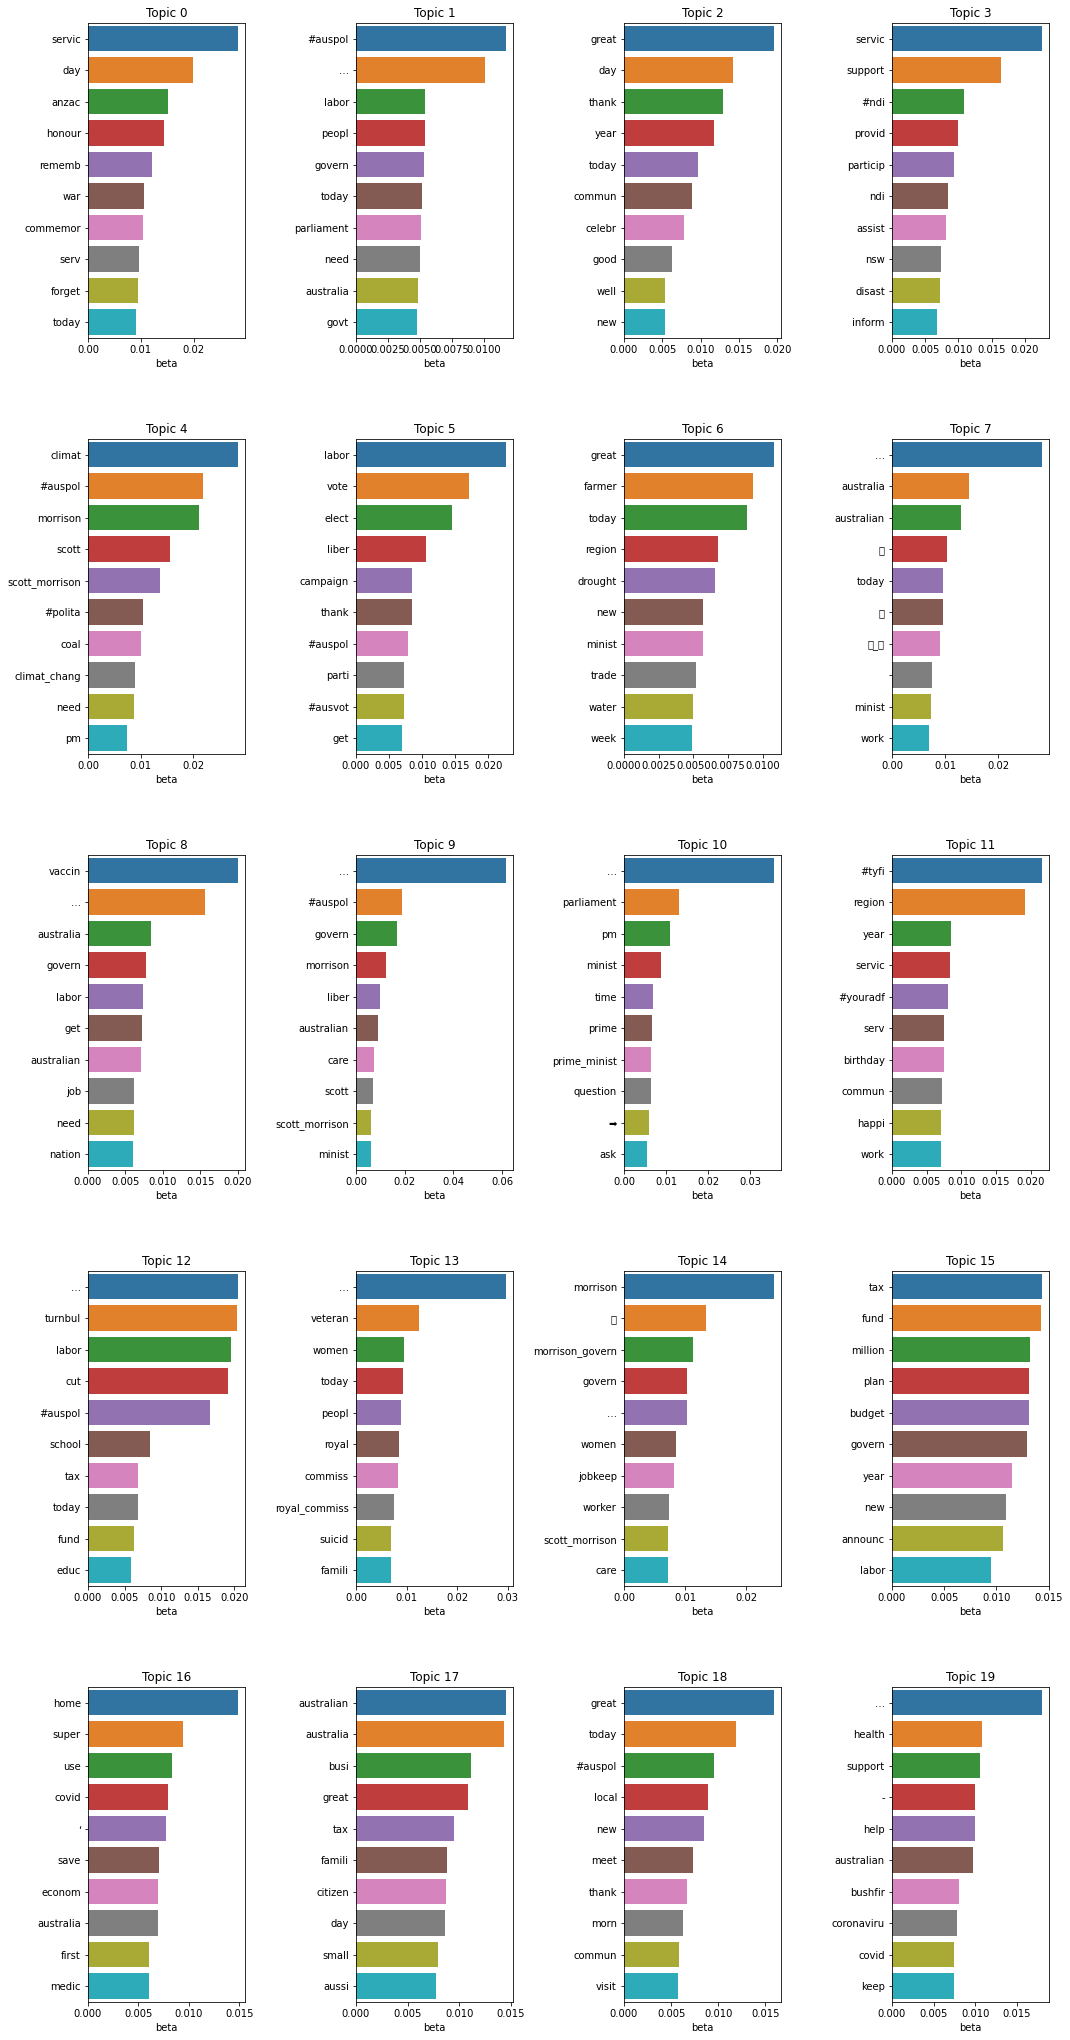

In [23]:
#Picking 20 topics to visualize
topics = list(range(0, 20))

fig, axes = plt.subplots(ncols=4, nrows=5, figsize = (16,30)) #Setting 20 subplots and determining figure size
fig.tight_layout(pad=8.0) #This ensure space between the subplots so the text can more easily be read
    
for ax, topic in zip(axes.flatten(), topics): #Iterates through the axes and the topics
    
    #Creates 20 barplots with x as the beta values and y as the words
    sns.barplot(ax = ax, 
                x = beta_df.iloc[topic].nlargest(10).values, 
                y = beta_df.iloc[topic].nlargest(10).index, 
                orient = 'h')
    
    ax.set(title='Topic {}'.format(topic), xlabel='beta')

plt.show()

In [24]:
#Insert the corpus of documents in bag of word format and get a list of (topic, probability) per document. 
document_topics = list(lda_model.get_document_topics(corpus)) 

#Creating a list of names for all 20 topics
topics = ['topic_{}'.format(t) for t in range(0,20)]

#Creating a dataframe of gamma probabilities 
gamma_probs = pd.DataFrame(np.zeros((len(document_topics),20)), columns = topics)

for i, doc in enumerate(document_topics): 
    for pair in doc: 
        gamma_probs.loc[i,'topic_{}'.format(pair[0])] = pair[1]

In [25]:
#Merging with the original dataframe 
gamma_df = pd.concat((tweets_agg,gamma_probs), axis = 1)

In [26]:
#Using regex to find all words and filter them from the weights
words = [re.findall(r'"([^"]*)"',t[1]) for t in lda_model.print_topics(20,10)]

# Printing the topics in a nice format
for id, t in enumerate(words): 
    print(f"------ Topic {id} ------")
    print(' '.join(t), end="\n\n")

------ Topic 0 ------
servic day anzac honour rememb war commemor serv forget today

------ Topic 1 ------
#auspol … labor peopl govern today parliament need australia govt

------ Topic 2 ------
great day thank year today commun celebr good well new

------ Topic 3 ------
servic support #ndi provid particip ndi assist nsw disast inform

------ Topic 4 ------
climat #auspol morrison scott scott_morrison #polita coal climat_chang need pm

------ Topic 5 ------
labor vote elect liber campaign thank #auspol parti #ausvot get

------ Topic 6 ------
great farmer today region drought new minist trade water week

------ Topic 7 ------
… australia australian 🇺 today 🇦 🇦_🇺 ️ minist work

------ Topic 8 ------
vaccin … australia govern labor get australian job need nation

------ Topic 9 ------
… #auspol govern morrison liber australian care scott scott_morrison minist

------ Topic 10 ------
… parliament pm minist time prime prime_minist question ➡ ask

------ Topic 11 ------
#tyfi region year 

In [27]:
# Date object
gamma_df["created_at"] = pd.to_datetime(gamma_df["created_at"])

In [ ]:
#Setting a theme
#sns.set_theme(style="darkgrid")

#Plotting a figure and setting figure size
#plt.figure(figsize = (14,8))

#Choosing colors

#Plotting the covid topic for the full dataset
#sns.lineplot(x = 'date', y = 'topic_3', hue = 'p.party', data = gamma_df)

#plt.title('Topic of support over time (Topic 3)', fontsize = 16)
#plt.ylabel('Topic prevalence')
#plt.xlabel('created_at')

#plt.show()